## Experimenting with the SIFT Feature Detector and Descriptor

SIFT approximates the LoG Filter that is convolved over the image for different sigma values with a Difference of Gaussian (DoG)

In [1]:
import numpy as np
import cv2 as cv
img = cv.imread('./../Feature_rich_image.jpg')
img_copy = img.copy()
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()


In [2]:
sift.setContrastThreshold(0.1) # The threshold to keep only prominent features and remove non-desirable features like edges
sift.setEdgeThreshold(15)
sift.setNOctaveLayers(12)
sift.setSigma(2)

In [3]:
keypoints, descriptors = sift.detectAndCompute(gray, None)
img_with_keypoints=cv.drawKeypoints(gray,keypoints,img)
cv.imwrite('sift_keypoints_for_Feature_rich_image.jpg',img_with_keypoints)

True

In [4]:
import matplotlib.pyplot as plt
img_with_keypoints = cv.imread('./sift_keypoints_for_Feature_rich_image.jpg')

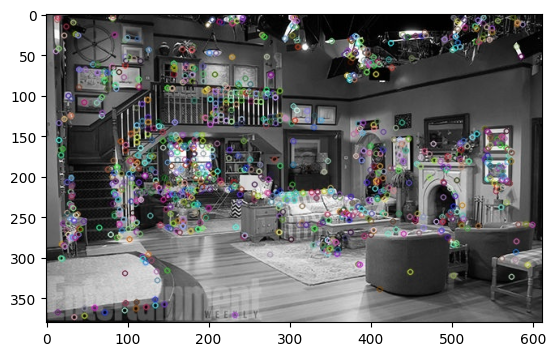

In [5]:
plt.imshow(img_with_keypoints)

## Experimenting with SURF (Speeded Up Robust Features)
The SURF Algorithm approximates the LoG algorithm with a simple Box Filter, thereby making things faster than SIFT
Whereas SIFT approximates the convolution of the normalized LoG over the image with DoG, SURF approximates it by calculating the determinant of the Hessian Matrix of the integral image colnvolved with a box filter. 

In [6]:
image_blurred_with_box_filter = cv.boxFilter(img_copy,ddepth = -1, ksize = (7,7))

### An example of colvolving the box filter over an image

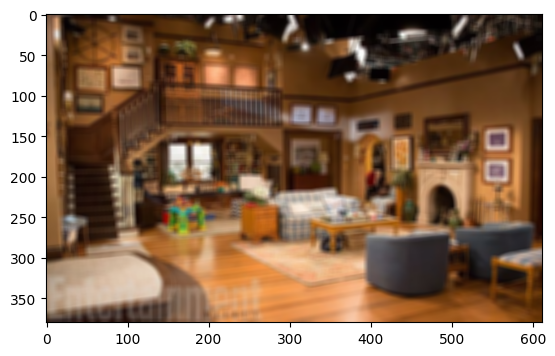

In [7]:
plt.imshow(cv.cvtColor(image_blurred_with_box_filter,cv.COLOR_BGR2RGB))

In [8]:
surf = cv.xfeatures2d.SURF_create(400)
kp, des2 = surf.detectAndCompute(image_blurred_with_box_filter,None)
img2 = cv.drawKeypoints(img,kp,None,(255,0,0),4)

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv_contrib\modules\xfeatures2d\src\surf.cpp:1028: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SURF::create'


## Using the Feature Descriptors to match features

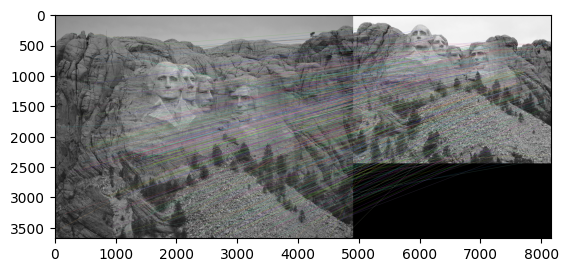

(<matplotlib.image.AxesImage at 0x14cd8794d30>, None)

In [10]:

query = cv.imread('./../img1.jpg',cv.IMREAD_GRAYSCALE)          # queryImage
key = cv.imread('./../img2.jpg',cv.IMREAD_GRAYSCALE) # trainImage
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(query,None)
kp2, des2 = sift.detectAndCompute(key,None)
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(query,kp1,key,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

### Extract Location of Good Matches in the images 

In [11]:
points1 = np.zeros((len(good), 2), dtype=np.float32)
points2 = np.zeros_like(points1)

In [12]:
good[0][0]

< cv2.DMatch 0000014CDA9CDA50>

In [13]:
points1.shape

(766, 2)

In [14]:
for i, match in enumerate(good):
    points1[i, :] = kp1[match[0].queryIdx].pt
    points2[i, :] = kp2[match[0].trainIdx].pt

In [15]:
points1[0]
points2[0]

array([591.92786, 635.0988 ], dtype=float32)

### Compute The Essential Matrix using these point matches

In [16]:
# Find the Essential Matrix using RANSAC
E, mask = cv.findEssentialMat(points1, points2, focal=1.0, pp=(0, 0), method=cv.RANSAC, prob=0.999, threshold=1.0)
_, R, t, _ = cv.recoverPose(E, points1, points2)

In [17]:
t

array([[-5.78078421e-01],
       [-8.15981047e-01],
       [ 5.20584267e-04]])

### Using Direct Linear Triangulation to compute the 3D points from the matched 2D points in the images 

In [18]:
fx = fy = 1
cx = cy = 0
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])

R1 = np.eye(3)
t1 = np.zeros((3, 1))

# For the second camera
R2 = R 
t2 = t 

# Projection matrices for both cameras, P = K[R|t]
P1 = K @ np.hstack((R1, t1))
P2 = K @ np.hstack((R2, t2))

# Assuming matched_pts1 and matched_pts2 are Nx2 arrays containing matched points from two images
# These points need to be in homogeneous coordinates for cv2.triangulatePoints
ones = np.ones((points1.shape[0], 1))
matched_pts1_h = np.hstack([points1, ones])
matched_pts2_h = np.hstack([points2, ones])

# Triangulate points
points_4d_hom = cv.triangulatePoints(P1, P2, points1.T, points2.T)

# Convert homogeneous coordinates to 3D
points_3d = points_4d_hom[:3] / points_4d_hom[3]


In [19]:
points_3d

array([[5.2664971e-01, 3.6738091e+00, 1.0671176e+00, ..., 1.1967384e+00,
        4.7502551e+00, 2.4424156e+01],
       [1.4916891e+00, 9.2009449e+00, 2.5672419e+00, ..., 6.9706440e-01,
        2.1495111e+00, 4.0272751e+00],
       [4.1772978e-04, 4.8973891e-03, 7.6333404e-04, ..., 2.6975444e-04,
        9.2280767e-04, 5.0973063e-03]], dtype=float32)

In [20]:
len(points_3d[points_3d > 0])

2232

In [26]:
points_3d.T[400]

array([4.9543595e+00, 2.3302915e+00, 1.9768151e-03], dtype=float32)